## やりたいこと
未知のデータに対する判定機能の要素実験

誤判定リスクを減らすため確率による判定を行う。と言ってもやっていることは地味で、
1. 新規データをAugmentationで水増し
1. 推論処理させる
1. 総データ数に対するTrueの割合を出し、50％を超えていたらTrue判定、そうでなければFalse判定

というとても簡単なもので、新しい処理系は基本必要ない…はず。

In [1]:
#%%
# cording = UTF-8
import os,re,random,copy                    #標準ライブラリ
import scipy,librosa,sklearn,joblib,h5py    #サードパーティライブラリ
import numpy as np
import pandas as pd                         #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras                #御呪い
import matplotlib.pyplot as plt

print ("Scipy version:{0}".format(scipy.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Tensorflow version:{0}".format(tf.__version__)) #赤線は無視
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("joblib version:{0}".format(joblib.__version__))
print ("h5py version:{0}".format(h5py.__version__))

####################################初期化####################################
aug_amount = 512    #ファイルごとのAugmentationの回数 2の階乗値
aug_length = 5      #Augmentation後のデータ長(秒) 音声データより長いこと
wav_sr = 22050      #音声ファイルのサンプリングレート 44100か22050

lr = 2e-02          #AE初期学習率
alpha = 0           #AEL2正則化の係数
dr_rate = 0.2         #AEドロップアウト率
batch_size = 256    #オフライン学習時のバッチサイズ
epochs = 100        #学習時のエポック数(グリッドサーチ時は無効)
encode_dim = 2048   #AE圧縮次元数
hidden_act = 'elu'  #AE隠れ層の活性化関数
out_act = 'linear'  #AE出力層の活性化関数

exp_ver = 0.999     #PCA圧縮率(保持する分散の割合)

monitor = "val_loss"    #学習率減衰/早期打ち切りの指標

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(base_dir,"data/OK")
ng_dir = os.path.join(base_dir,"data/NG")
env_dir = os.path.join(base_dir,"data/Environment")
env_file = "masuho_env.wav"
log_dir = "./logs"       #Tensorboardログの保存パス
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
dataset_file = "dataset2020.npz"


Scipy version:1.4.1
Numpy version:1.18.4
Pandas version:1.0.3
Tensorflow version:2.2.0
tf.keras version:2.3.0-tf
Scikit-Learn version:0.23.1
joblib version:0.15.1
h5py version:2.10.0


In [2]:
##############################定義系オブジェクト##############################

#Augmentationのメソッド定義クラス
class Aug_method:
    def __init__(self):
        pass

    #対象フォルダ内のWaveファイルの一覧を取得
    def wav_search(self,dir):
        #初期化
        x = []

        #os.chdir(dir)
        for i in os.listdir(dir):
            search_index = re.search('.wav',i)
            if search_index:
                x.append(i)
        
        print("Files to process:\n\
        {}".format(x))
        
        return x

    #オーディオファイルの読み込み モノラル固定
    def load_wav(self,dir,file,rate = 44100):
        #初期化
        x = np.arange(0)

        x,y = librosa.load(
            os.path.join(dir,file),
            sr = rate,
            mono =True
        )

        del y
        return x

    #Augmentation処理1 データの耳をそろえてスタート位置を変更
    #これでファイルサイズサーチが必要なくなる…はず
    def shift_wav(self,wav,rate,length):

        #初期化
        x = np.arange(0)

        shift_val=int(rate*length) - int(len(wav))

        x = np.roll(
            np.concatenate(
                [wav,np.zeros(shift_val)]
            ),
            random.randint(0,shift_val)
        )

        return x

    #Augmentation処理2 ノイズの追加
    def add_noize(self,wav):

        x = wav + np.random.randn(len(wav))*random.uniform(0,0.0001)
        return x

    #音声のランダム切り出し(主に環境音データ用)
    def wav_extraction(self,wav,rate,length):

        width = int(rate*length)
        start = random.randint(0,int(len(wav)-width))   #最大でもwidth分は残す

        x = copy.deepcopy(wav[start:start+width])

        return x

    #スペクトログラム取得 スペクトラムスケール・マグニチュード
    def get_spg(self,wav,rate):
        
        #初期化
        x = np.arange(0)

        freq,time,x = scipy.signal.spectrogram(
            wav,
            fs = rate,
            window = np.hamming(1024),
            nfft = 1024,
            scaling = "spectrum",
            mode = "magnitude"
        )
        return freq,time,x

#データ前処理のクラス
class Pproc:
    def __init__(self):
        pass

    #TrainとTestを分離
    def t_t_sprit(self,X_data,y_data,test_size):
        X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(
            X_data.reshape(len(X_data),-1),
            y_data,
            test_size = test_size)
        return X_train,X_test,y_train,y_test

    #スケーラー
    #def scaler(self):
    #    x = sklearn.preprocessing.MinMaxScaler()
    #    return x

    #AE学習用 Falseデータだけ抽出
    def m_sprit(self,X,y):
       #呼び出されるごとに初期化する
        try:
            x
        except:
            pass    #xが存在しなければ何もしない
        else:
            del x #前のデータを消去する

        #y_mixedをboolianindexと見なし、論理値を反転してX_mixedから抽出
        x = X[np.logical_not(y)]

        return x

#分類機の定義
class Estimator:
    def __init__(self):
        pass

    #オートエンコーダの定義
    def AE(self,input_dim,encode_dim,lr,alpha,dr_rate,hidden_act,out_act):
        input_data = tf.keras.layers.Input(shape = (input_dim,))

        #エンコーダを定義
        encoder = tf.keras.layers.Dense(
            encode_dim,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(alpha),
            )(input_data)
        encoder = tf.keras.layers.BatchNormalization()(encoder)
        encoder = tf.keras.layers.Dropout(dr_rate)(encoder)
        encoder = tf.keras.layers.Activation(hidden_act)(encoder)

        #デコーダを定義 こっちにはドロップアウトは定義しない
        decoder = tf.keras.layers.Dense(
            input_dim,kernel_initializer="he_normal")(encoder)
        decoder = tf.keras.layers.BatchNormalization()(decoder)
        decoder = tf.keras.layers.Activation(out_act)(decoder)

        #モデルを定義
        x = tf.keras.Model(
            inputs = input_data,
            outputs = decoder
        )

        #最適化関数
        opt = tf.keras.optimizers.Nadam(lr = lr)

        x.compile(
            optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
            )

        return x

    #コールバック定義 早期打ち切り
    def cb_es(self,monitor):
        x = tf.keras.callbacks.EarlyStopping(
            monitor = monitor,
            patience= 3,
            min_delta = 0.0001)
        return x

    #コールバック定義 TensorBordへの出力 バリデーションデータの指定が必須
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_tb(self,log_dir):
        x = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            )
        return x

    #コールバック定義 自動学習率減衰(もともとNadamは減衰する decay=0.004)
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_rd(self,monitor):
        x = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = monitor,
            factor = 0.1,
            patience = 2,
            verbose= 1,
            min_lr = 1e-08
            )
        return x

    #コールバック定義 モデル保存
    #Tensorflow2.1.0 / keras 2.2.4-tfでは不具合があるらしい
    def cb_cp(self,modeldir,monitor):
        x = tf.keras.callbacks.ModelCheckpoint(
            filepath = os.path.join(modeldir,"AEmodel.hdf5"),
            monitor = monitor,
            save_best_only=True
        )
        '''
        以下備忘
        https://qiita.com/yukiB/items/f45f0f71bc9739830002 より

        >modelの保存，読み込みはmodel.to_json()/model.to_yaml()，
        >model_from_json()/model_from_yaml()を使用します．

        '
        from keras.models import Sequential, model_from_json

        json_string = model.to_json()
        model = model_from_json(json_string)
        '

        >学習したParameterの保存＆読み込みは，
        >save_weights/load_weightsを使用します(h5pyが必要)．

        '
        model.save_weights('param.hdf5')
        model.load_weights('param.hdf5')
        '
        '''
        return x

    #PCAによる疑似エンコーダの定義 指定された保持分散率に基づき次元数を求める       
    def Pseudo_AE(self,X,exp_ver = 0.999):
        model = sklearn.decomposition.IncrementalPCA()
        model.fit(X)
        n_components = np.argmax(
            np.cumsum(
                model.explained_variance_ratio_
                ) >= exp_ver
            ) +1
        
        #分散保持率と次元数をプロット
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.scatter(n_components,exp_ver)
        plt.xlabel("Dimensions")
        plt.ylabel("Explained Variance")
        plt.title(
            "Explained Ver:" + str(exp_ver) + \
                " -> Dimensions:" + str(n_components)
            )
        plt.show()    
 
        del model
        x = sklearn.decomposition.IncrementalPCA(
            n_components = n_components
            )
        x.fit(X)

        return x

#モデルの保存・ロード関連
class serialize:
    def __init__(self):
        pass

    #AEモデルセーブ(モデル単体 メンテ擁)
    def AE_save(self,model,modeldir,fileAE = "AEmodel.hdf5"):
        model.save(
            filepath = os.path.join(modeldir,fileAE),
        )
        print("Autoencoder model saved!!")

    '''
    モデルファイルの圧縮機能
    https://kuune.org/text/2017/05/06/compress-and-save-keras-model/

    '''

    #AEモデルのロード(モデル単体 メンテ要)
    def AE_load(self,modeldir,fileAE = "AEmodel.hdf5"):
        model = tf.keras.models.load_model(
            filepath = os.path.join(modeldir,fileAE)
        )
        print("Model loded!!")
        return model

    #モデルデータと閾値のパッケージング
    def pack_model_thresh(self,model,thresh):
        x = {"model":model,"thresh":thresh}
        return x
    
    #パッケージデータからモデルと閾値を取り出す
    def unpack_model_thresh(self,obj):
        model = obj["model"]
        thresh = obj["thresh"]
        return model,thresh

    #joblibでの保存
    def jb_save(self,obj,modeldir,modelname = "PCAmodel.dat"):
        joblib.dump(
            obj,os.path.join(modeldir,modelname)
        )
        print("Model saved!")

    #joblibのロード
    def jb_load(self,modeldir,modelname = "PCAmodel.dat"):
        obj = joblib.load(
            os.path.join(modeldir,modelname)
        )
        print("Model loded!!")
        return obj

#誤差(MSE)および決定境界の計算
class Error_calc:
    def __init__(self):
        pass
    
    #MSEの計算
    def calc_mse(self,X,X_decode,y):
        x = np.zeros(y.shape)
        for i in range(X.shape[0]):
            x[i] = sklearn.metrics.mean_squared_error(
                X[i],X_decode[i]
                )
        return x

    #分類境界の計算
    def calc_thresh(self,y,mse):
        x = (
            (
                (mse[y].min() - mse[np.logical_not(y)].max()) / 2
                ) + mse[np.logical_not(y)].max()
            )
        print("threshold:{}".format(x))
        return x

    #MSEと分離境界を計算する
    def clf_thresh(self,X,X_decode,y):
        mse = self.calc_mse(X,X_decode,y)
        if mse[y].min() > mse[np.logical_not(y)].max():
            thresh =self.calc_thresh(y,mse)
        else:
            print ("Cannot define classification threshold!!")
            thresh = None

        return mse,thresh

#推論処理
class Predictor:
    def __init__(self):
        pass

    #デコーダ(AE用)
    def AE_decode(self,X,model):     #,scaler
        x = model.predict(X)
        print ("Prediction is finished!!")

        return x

    #デコーダ(疑似AE用)
    def PsdAE_decode(self,X,model):      #,scaler
        x = model.inverse_transform(
            model.transform(X)
        )                               #次元削減して元に戻す
        print ("Prediction is finished!!")

        return x

    #y_predの生成処理
    def mse_predictor(self,mse,thresh):
        x = np.zeros(len(mse),dtype=bool)
        for i in range(len(mse)):
            if mse[i] < thresh:
                x[i] = False
            else:
                x[i] = True

        return x

    #モデルの評価
    def model_evaluate(self,y_true,y_pred):
        print("Classification report:\n{}".format(
            sklearn.metrics.classification_report(
                y_true,y_pred
            )
        ))
        print ("Confusion Matrix:\n{}".format(
            sklearn.metrics.confusion_matrix(
                y_true,y_pred
            )
        ))

#可視化
class Visualizer:
    def __init__(self):
        from matplotlib.colors import LogNorm
    
    #オートエンコーダの学習曲線の可視化
    def vis_learn_curve(self,hist):
        plt.subplot(121)
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.legend(["Train","val"])
        plt.title("Accuracy")

        plt.subplot(122)
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.legend(["Train","val"])
        plt.title("Loss")

        plt.show()
    
    #復元状況の可視化関数
    def vis_error(self,i,X,X_decode,y,y_pred,X_shape,mse):
        from matplotlib.colors import LogNorm
        plt.subplot(311)
        plt.pcolormesh(
            X[i].reshape(X_shape),
            norm = LogNorm()
        )
        plt.colorbar()
        plt.yscale("Log")
        plt.title("Data:" + str(y[i]))

        plt.subplot(312)
        plt.pcolormesh(
            X_decode[i].reshape(X_shape),
            norm = LogNorm()
        )
        plt.colorbar()
        plt.yscale("Log")
        plt.title("Predict:" + str(y_pred[i]))

        plt.subplot(313)
        plt.pcolormesh(
            np.abs(X[i]-X_decode[i]).reshape(X_shape),
            norm = LogNorm()
        )
        plt.colorbar()
        plt.yscale("Log")
        plt.title("MSE:" + str(mse[i]))

        plt.show()
    
    #分離境界の可視化
    def vis_mse(self,y,mse,thresh):
        plt.scatter(
            y[np.logical_not(y)],
            mse[np.logical_not(y)],
            color = "#0000ff",
            linestyle='None',
            label = "False"
            )
        plt.scatter(
            y[y],
            mse[y],
            color = "#ff0000",
            linestyle='None',
            label = "True"
            )
        plt.plot(
            np.arange(2),
            np.array([thresh,thresh]),
            color = "#000000",
            linestyle = "--"
            )
        plt.xlabel("Bool_val")
        plt.ylabel("MSE")
        plt.yscale("log")
        plt.title("Decoding error (MSE) and separation threshold")
        plt.legend()
        plt.show()

#############################処理系オブジェクト#############################
#Augmentationの処理クラス
class Proc_aug(Aug_method):
    def __init__(self):
        pass

    #単一のファイルに対する水増し操作
    def aug_data(self,wav,env_wav,rate,length,amount):
        for i in range(amount):
            # 1.読み込んだデータを成形しスタート位置をランダムシフト
            wf = super().shift_wav(wav,rate,length)

            # 2.環境音データをランダムで切り出し、wfに貼り付ける
            env = super().wav_extraction(env_wav,rate,length)
            wf = wf + ( env * random.uniform(0.001,0.1)) #環境音側の音量を振る

            # 3.全体に一様分布のノイズを付与
            wf = super().add_noize(wf)
            
            #スペクトラムを得る
            freq,time,spg = super().get_spg(wf,rate)
            spg = spg.reshape(1,len(freq),len(time))    #3次元配列に変換

            #ファイルを積み上げる
            try:
                x
            except:
                x = copy.deepcopy(spg)
            else:
                x = np.vstack((x,spg))

            del wf,env,spg,freq,time
        
        return x,i

    #データセットの作成
    def aug_dataset(self,dir,env_wav,rate,length,amount):
        #ウェーブリストを読み込む
        wave_list = self.wav_search(dir)
        #カウンター変数のリセット
        counter = 0 
        #ウェーブリストを変数としてforループを組む
        for i in wave_list:
            #load_wavでファイルを読み出し、aug_dataに渡す
            wav = super().load_wav(dir,i,rate)
            auged_spg,count = self.aug_data(wav,env_wav,rate,length,amount)
            del wav
            
            #データをスタックし、混ぜる(追加学習を見越して)
            try:
                x
            except:
                x = copy.deepcopy(auged_spg)
            else:
                x = np.vstack((x,auged_spg))

            #カウンターを積み上げる
            counter = counter + count
            print ("Augmentation count = {}".format(count))

        #出来上がったデータを混ぜる
        np.random.shuffle(x)
        #変数を返す前に中間生成物を消去
        del env_wav,auged_spg,count,counter
        #変数を返す
        return x

    #初期学習用データセットの作成とセーブ・ロード
    def make_dataset(self,data_dir,ok_dir,ng_dir,env_dir,env_file,rate,length,amount,dataset_f):
        #環境音を読み込む
        print ("Enviroment wave loading...")
        env_wav = super().load_wav(env_dir,env_file,rate)
        
        print ("Creating dataset...")
        #OKDirをaug_datasetに渡してOKデータセット作成
        X_ok = copy.deepcopy(
            self.aug_dataset(ok_dir,env_wav,rate,length,amount)
            )
        y_ok = np.zeros(len(X_ok),dtype = 'bool')   #OKデータをfalse(陰性)と定義
            #NGDirをaug_datasetに渡してNGデータセット作成
        X_ng = copy.deepcopy(
            self.aug_dataset(ng_dir,env_wav,rate,length,amount)
        )            
        y_ng = np.ones(len(X_ng),dtype = 'bool')    #NGデータをTrue(陽性)と定義
        #両者をスタック
        X_data = np.vstack((X_ok,X_ng))
        y_data = np.append(y_ok,y_ng)
        del X_ok,y_ok,X_ng,y_ng
        
        #保存する
        np.savez_compressed(os.path.join(data_dir,dataset_f),
        X = X_data,y = y_data)
        print("Data set saved! : {}".format(str(dataset_f)))

        return X_data,y_data

    def load_dataset(self,data_dir,dataset_f):
        load_data = np.load(os.path.join(data_dir,dataset_f))
        X_data =load_data['X']
        y_data = load_data['y']
        del load_data
        print("Data loaded!!")

        return X_data,y_data

#オートエンコーダのための前処理
class Offl_pproc(Pproc):
    
    #トレーニング/テストデータ分離、False分離、スケーリング
    def offl_pproc(self,X_data,y_data):
        X_train,X_test,y_train,y_test = super().t_t_sprit(
            X_data,y_data,
            test_size=0.05
            )
        print("train/test sprited!!")
        del X_data,y_data

        X_train_ae = super().m_sprit(X_train,y_train)
        print(
        "X_train for Autoencoder was splited!!\n\
        amount/shape:{0}"
        .format(X_train_ae.shape)
        )

        #後で使うためにスケーラーをインスタンス化しておく
        #scaler = super().scaler()
        #X_train_ae = scaler.fit_transform(X_train_ae)
        #print("Scaling process is over!!")

        return X_train,X_test,y_train,y_test,X_train_ae #,scaler

#初期オフライン学習 学習→テストデータ推論→デコードまで
class Offl_train(Estimator,Predictor,Visualizer):
    
    #AEによる初期学習
    def offl_AE_train(
        self,X,X_ae,encode_dim,lr,alpha,dr_rate,
        epochs,batch_size,hidden_act,out_act,monitor
        ):  #,log_dir,modeldir
        #エンコーダのインスタンス化
        x = super().AE(
                input_dim = X_ae.shape[1],
                encode_dim = encode_dim,
                lr = lr,
                alpha = alpha,
                dr_rate = dr_rate,
                hidden_act = hidden_act,
                out_act = out_act
            )
        #コールバックの定義 今は早期打ち切りしか使ってない
        cb_es = super().cb_es(monitor = monitor)

        hist = x.fit(
            X_ae,X_ae,
            epochs = epochs,
            batch_size = batch_size,
            callbacks = [cb_es], #,cb_rd,cb_tb うまく動かない
            validation_split = 0.05,
            shuffle = True,
            use_multiprocessing=True
            )

        print('Autoencoder learning is over!')
        x.summary()

        #学習曲線の表示
        super().vis_learn_curve(hist)

        #デコード処理
        X_dec = super().AE_decode(X,x)
        print("Learning and inference of test data is over!")

        return x,hist,X_dec

    #疑似AEによる初期学習
    def offl_PsdAE_train(self,X,X_ae,exp_ver):
        #エンコーダのインスタンス化
        x = super().Pseudo_AE(
                X_ae,exp_ver
                )
        #学習処理
        x.fit(X_ae)
        hist = x

        #学習後の次元数を表示
        print(
            "PusedoAE learning is over!\n\
        n_components = {0}"
        .format(hist.n_components_)
        )

        #デコード処理
        X_dec = super().PsdAE_decode(X,x)
        print("Learning and inference of test data is over!")

        return x,hist,X_dec

#初期の分離境界を設定
class Calc_init_error(Error_calc,Visualizer,serialize):
    def __init(self):
        pass

    def calc_init_error(self,X,X_dec,y,model,modeldir):
        mse,thresh = super().clf_thresh(
            X,X_dec,y
            )
        super().vis_mse(y,mse,thresh)

        #モデル保存の条件分岐 0か1が押されるまでループ
        key = ""
        while key == "0" or "1":
            key = input("Do you want to save the trained model? [0:yes 1:no]")
            if key == "0":
                super().jb_save(
                    super().pack_model_thresh(model,thresh),
                    modeldir
                    )
                break
            elif key =="1":
                print("Didn't save.")
                break
        
        del key

        return mse,thresh

#テストデータによる推論と評価
class Evaluation(Predictor,Error_calc,Visualizer):
    def __init__(self):
        pass

    def test_pred(self,X,y,model,thresh):
        if "keras" in str(type(model)):
            X_dec = super().AE_decode(X,model)
        else:
            X_dec = super().PsdAE_decode(X,model)
        #将来的にelif "sklearn" in str(type(model))にして
        #elseの場合処理を中止させる
        
        mse = super().calc_mse(X,X_dec,y)
        y_pred = super().mse_predictor(mse,thresh)

        #レポートと分離状況の表示
        print("prediction and evaluation done!\n\
        threshhold = {}".format(thresh))
        super().model_evaluate(y_test,y_pred)
        super().vis_mse(y_pred,mse,thresh)

        return y_pred,mse

#オートエンコーダグリッドサーチの実行(まだ動かない)
class AE_GS(Estimator):
    def __init__(self):
        pass
    
    def GS_param(self):
        pm = {
            'alpha':[1,0.01,1e-04,1e-06,1e-08],
            'lr':[1,0.01,1e-04,1e-06,1e-08],
            'dr_rate':[0.2],
            'batch_size':[50],
            'epochs':[10]
        }
        return pm

    #グリッドサーチの定義から処理まで一気に行う
    def GS_fit(
        self,X_train_ae,encode_dim,lr,alpha,dr_rate,
        epochs,batch_size,hidden_act,out_act
        ):
        
        #Sklearnでラップ
        x = keras.wrappers.scikit_learn.KerasClassifier(
            build_fn = super().AE(
                input_dim = X_train_ae.shape[1],
                encode_dim = encode_dim,
                lr = lr,
                alpha = alpha,
                dr_rate = dr_rate,
                hidden_act = hidden_act,
                out_act = out_act
            ),
            epochs = epochs,
            batch_size = batch_size
        )  

        #サーチの実行
        y = sklearn.model_selection.GridSearchCV(
            estimator = x,
            param_grid = self.GS_param(),
            return_train_score = True,
            cv = 3,
            verbose = 2
        )
        
        y.fit(X_train_ae,X_train_ae)

        #レポートの表示
        print('Gridsearch is over!')
        print("Best parameters :{}".format(y.best_params_))
        print("Best cross-validation score :{}".format(y.best_score_))

        #テスト結果の一覧表示(データフレーム使用)
        #results_df = pd.DataFrame(y.cv_results_)
        #display(results_df)

        #ヒートマップの描画
        pm = self.GS_param()
        plt.pcolormesh(
            np.array(y.cv_results_['mean_test_score']).reshape(
                len(pm['alpha']),len(pm['lr'])
                )
            )
        plt.title('Result')
        plt.ylabel("alpha")
        plt.yticks(np.arange(len(pm['alpha'])),pm['alpha'])
        plt.xlabel("Larning Rate")
        plt.xticks(np.arange(len(pm['lr'])),pm['lr'])
        plt.colorbar()
        plt.show()

        return y


In [3]:
#分類器のロード
ser = serialize()
model,clf_thresh = ser.unpack_model_thresh(ser.jb_load(modeldir))

Model loded!!


---
## Trueと判定してほしい未知データに対する実験

In [4]:
#未知のデータに対する判定処理
Aug = Aug_method()

#環境音を読み込む
print ("Enviroment wave loading...")
env_wav = Aug.load_wav(env_dir,env_file,wav_sr)

#判定音を読み込む
wav = Aug.load_wav(
    os.path.join(base_dir,"data/validation"),
    "ok_plain_5.wav",
    wav_sr
)

#この下はPproc_aug.aug_dataの丸写し。
for i in range(127):
    wf = Aug.shift_wav(wav,wav_sr,aug_length)
    env = Aug.wav_extraction(env_wav,wav_sr,aug_length)
    wf = wf + ( env * random.uniform(0.001,0.1))
    wf = Aug.add_noize(wf)
    freq,time,spg = Aug.get_spg(wf,wav_sr)
    spg = spg.reshape(1,len(freq),len(time))

    try:
        X_new
    except:
        X_new = copy.deepcopy(spg)
    else:
        X_new = np.vstack((X_new,spg))

    del wf,env,spg,freq,time

X_new = X_new.reshape(len(X_new),-1)
Eval = Evaluation()
X_new_dec = Eval.PsdAE_decode(X_new,model)
#この下は本来Error_calc.calc_mseだが、引数の設計が良くなくて丸写し
new_mse = np.zeros(X_new.shape[0])
for i in range(X_new.shape[0]):
    new_mse[i] = sklearn.metrics.mean_squared_error(
        X_new[i],X_new_dec[i]
    )

y_new = Eval.mse_predictor(new_mse,clf_thresh)

Enviroment wave loading...
Prediction is finished!!


処理系自体は事前学習と同じものを使用している。クラスの配置や引数定義がよろしくないものがあるので、今後修正要(末尾参照)

In [5]:
print (y_new)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


In [6]:
print (new_mse)

[1.54492815e-06 1.49972733e-06 1.46144805e-06 1.49872470e-06
 1.46242615e-06 1.47613559e-06 1.45357509e-06 1.46232645e-06
 1.56142996e-06 1.47792944e-06 1.47145076e-06 1.47765588e-06
 1.46818491e-06 1.47894948e-06 1.50377192e-06 1.50537718e-06
 1.46015293e-06 1.48594619e-06 1.48079363e-06 1.49069916e-06
 1.48813958e-06 1.48963071e-06 1.46343044e-06 1.48464397e-06
 1.50635253e-06 1.49274454e-06 1.50525222e-06 1.49213078e-06
 1.55611087e-06 1.52428887e-06 1.77002483e-06 1.46050617e-06
 1.44440961e-06 1.48253646e-06 1.55524019e-06 1.45382141e-06
 1.44873890e-06 1.48984576e-06 1.49730977e-06 1.49494717e-06
 1.48018933e-06 1.46581528e-06 1.46741050e-06 1.48292975e-06
 1.45961423e-06 1.49152391e-06 1.49107977e-06 1.47003335e-06
 1.46575227e-06 1.49833991e-06 1.56947346e-06 1.45985523e-06
 1.46402238e-06 1.48312685e-06 1.76732154e-06 1.58728859e-06
 1.57715695e-06 1.46469875e-06 1.46013239e-06 1.46768070e-06
 1.48514268e-06 1.51539427e-06 1.83523797e-06 1.54923836e-06
 1.49561507e-06 1.490924

In [7]:
print (clf_thresh)

1.282626328051534e-06


誤判定しているが、MSEが閾値にかなり近い。

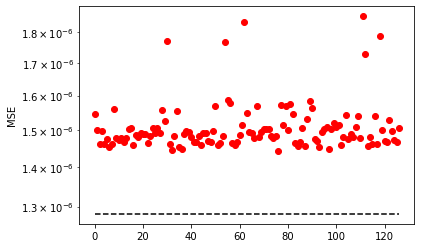

In [8]:
#確率モデルの各判定と判定閾値の関係を見てみる
plt.scatter(
    np.arange(127),
    new_mse,
    color = "#ff0000",
    linestyle='None'
)
plt.plot(
    np.arange(127),
    np.full(127,clf_thresh),
    color = "#000000",
    linestyle = "--"
)
plt.ylabel("MSE")
plt.yscale("Log")
plt.show()

平均すると1.5e-06ぐらいの値になっている。Augmentationによってばらつきも発生しており、確率モデル化する意味はありそうだ

## Trueと判定してほしい未知データに対する実験

Prediction is finished!!
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[3.38613509e-06 3.13126734e-06 3.24915104e-06 3.24105594e-06
 3.31771622e-06 3.31211796e-06 3.22708538e-06 3.31318315e-06
 3.22816226e-06 3.30783597e-06 3.19712958e-06 3.37861018e-06
 3.23333739e-06 3.

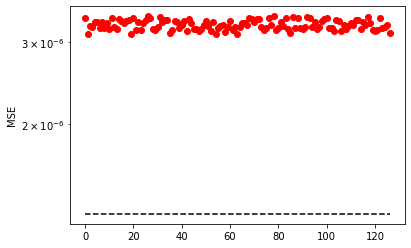

In [10]:
#Trueとわかっているデータに対して同じことをやってみる
del wav,X_new,X_new_dec,new_mse,y_new
wav = Aug.load_wav(
    os.path.join(base_dir,"data/validation"),
    "NG_plane5.wav",
    wav_sr
)

for i in range(127):
    wf = Aug.shift_wav(wav,wav_sr,aug_length)
    env = Aug.wav_extraction(env_wav,wav_sr,aug_length)
    wf = wf + ( env * random.uniform(0.001,0.1))
    wf = Aug.add_noize(wf)
    freq,time,spg = Aug.get_spg(wf,wav_sr)
    spg = spg.reshape(1,len(freq),len(time))

    try:
        X_new
    except:
        X_new = copy.deepcopy(spg)
    else:
        X_new = np.vstack((X_new,spg))

    del wf,env,spg,freq,time

X_new = X_new.reshape(len(X_new),-1)

Eval = Evaluation()
X_new_dec = Eval.PsdAE_decode(X_new,model)
new_mse = np.zeros(X_new.shape[0])
for i in range(X_new.shape[0]):
    new_mse[i] = sklearn.metrics.mean_squared_error(
        X_new[i],X_new_dec[i]
    )

y_new = Eval.mse_predictor(new_mse,clf_thresh)

print(y_new)
print(new_mse)
plt.scatter(
    np.arange(127),
    new_mse,
    color = "#ff0000",
    linestyle='None'
)
plt.plot(
    np.arange(127),
    np.full(127,clf_thresh),
    color = "#000000",
    linestyle = "--"
)
plt.ylabel("MSE")
plt.yscale("Log")
plt.show()

無事True判定しているが、思ったよりもMSEが低く出ている。

In [18]:
#確率による判定
if np.count_nonzero(y_new)/len(y_new) >0.5:
    print("NG(True)")
else:
    print("OK(False)")
print("MSE:{0},Threshold:{1}".format(
    np.mean(new_mse),
    clf_thresh
))

NG(True)
MSE:3.274008605472736e-06,Threshold:1.282626328051534e-06


確率判定自体は引数さえあれば簡単なコードでできてしまう。

## わかったこと
- ok_plain5.wavは偽陽性のサンプルファイルとして使える
- 基本は偽陽性なら閾値の変更、偽陰性は追加学習という方針だが、追加学習のサンプル＆効果検証としても使用する予定
- 正直誤判定をしてくれるとは思っていなかった(しかもいい感じの誤判定)のでうれしい誤算


## 次にやること
- 今回実装した処理のクラスモジュール化
- 既存クラスモジュールの一部修正
    - `aug_data`メソッドを`class Pproc_aug`から`class Aug_method`に移動
    - `Error_calc.calc_mse`の引数`y`を削除。取り込んだ`X`の`shape[0]`で取得できる
- 閾値変更の検討  
    誤判定データのMSEの分散を取り、平均+分散分を新しい閾値とする(確率モデルで許容できるギリギリを狙う)
- 追加学習の検討  
    挙動によっては、`sklearn.decomposition.IncrementalPCA`の実装を変える必要があるかも